In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
import json
import cv2
import numpy as np
from os.path import isdir, join
Settings = json.load(open('settings.json'))
dataset_dir = Settings['dataset']
n_cameras = Settings['n_cameras']
assert isdir(dataset_dir), dataset_dir
vid_dir = join(dataset_dir, 'videos')
assert isdir(vid_dir), vid_dir
cam_dir = join(dataset_dir, 'cameras')
assert isdir(cam_dir), cam_dir
FRAME = 1
from aik.dataset import AIK

aik = AIK(dataset_dir)

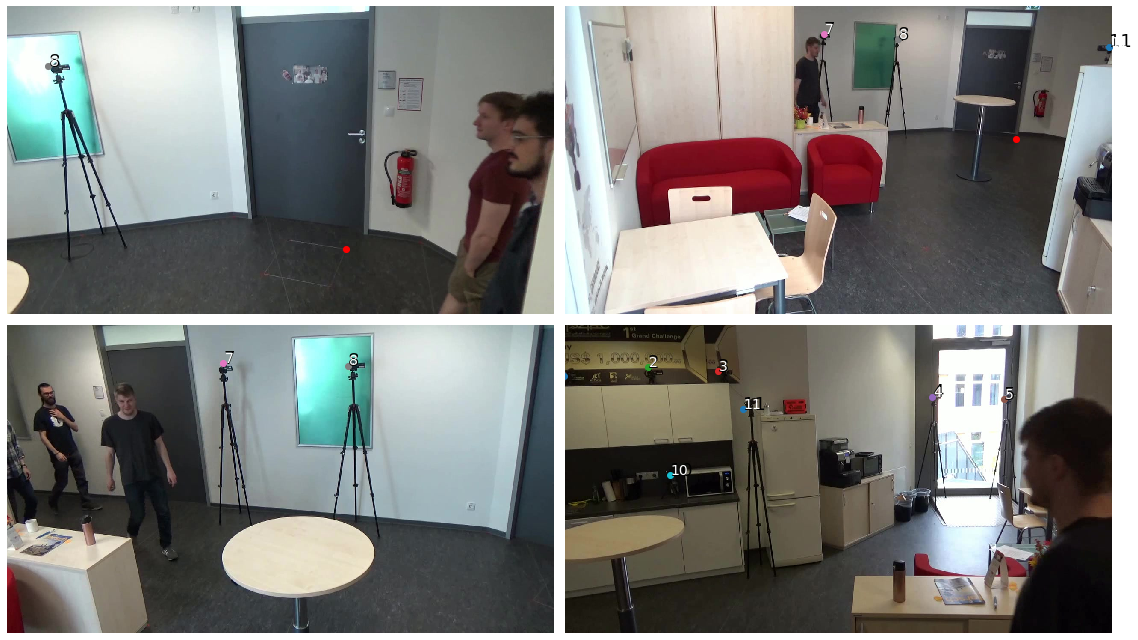

In [2]:
selected_cids = [0, 5, 2, 7]


I, Calib = aik.get_frame(20)

pts3d = (0, 0, 0)

fig = plt.figure(figsize=(16, 9))

for i, cid in enumerate(selected_cids):
    cam = Calib[cid]
    ax = fig.add_subplot(2, 2, i + 1)
    ax.axis('off')
    ax.set_xlim([0, cam.w])
    ax.set_ylim([cam.h, 0])
    ax.imshow(I[cid])
    
    pt2d = cam.project_points(pts3d)
    zero = pt2d[0]
    
    ax.scatter(zero[0], zero[1], color='red')
    
    for cid_other in range(n_cameras):
        if cid_other == cid:
            continue
        cam_other = Calib[cid_other]
        C = cam_other.location()
        x, y = np.squeeze(cam.project_points(C))
        ax.scatter(x, y)
        if x > 0 and y > 0 and x < cam.w and y < cam.h:
            ax.text(x, y, str(cid_other), color='black', fontsize=18)
            ax.text(x+3, y-2, str(cid_other), color='white', fontsize=14)
            
    

plt.tight_layout()
plt.show()

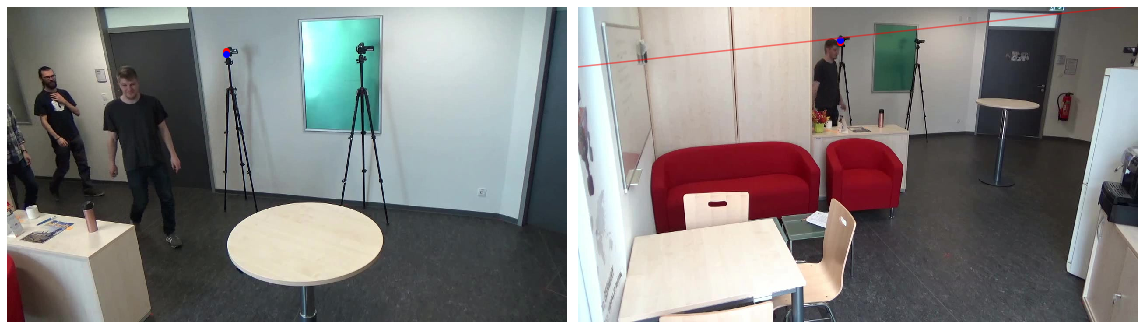

In [3]:
import aik.geometry as gm

cid1 = 2
cid2 = 5

im1 = I[cid1]
im2 = I[cid2]

cam1 = Calib[cid1]
cam2 = Calib[cid2]

pt1 = [500, 100]
pt2 = [600,  80]
pt3d = gm.triangulate(pt1, pt2, cam1, cam2)


# ax + by + c = 0 ==> y = (-c -ax)/b
epiline = gm.compute_epiline(pt1, cam1, cam2)
y = lambda x, a, b, c: (-c - a * x)/b

x0 = 0
y0 = y(x0, *epiline)

x1 = 1600
y1 = y(x1, *epiline)


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.imshow(im1); ax.axis('off')
ax.scatter(*pt1, color='red')
pt1_reprojected = np.squeeze(cam1.project_points(pt3d))
ax.scatter(*pt1_reprojected, color='blue')
ax.set_xlim([0, cam1.w])
ax.set_ylim([cam1.h, 0])

ax = fig.add_subplot(122)
ax.imshow(im2); ax.axis('off')
ax.scatter(*pt2, color='red')
pt2_reprojected = np.squeeze(cam2.project_points(pt3d))
ax.scatter(*pt2_reprojected, color='blue')
ax.set_xlim([0, cam1.w])
ax.set_ylim([cam1.h, 0])
ax.plot([x0, x1], [y0, y1], color='red', alpha=0.5)

plt.tight_layout()
plt.show()

In [4]:
from aik.camera import Camera

json = cam1.to_json()

cam = Camera.from_json(json)

cam.P.shape

(3, 4)